# Climate Analysis

Assume my vacation date was from 2017-12-24 to 2018-01-01.

In [1]:
from datetime import datetime, timedelta, date
from dateutil.relativedelta import relativedelta
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
from sqlalchemy import create_engine, select, func, desc, and_
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session

sns.set(font_scale=1.5)
sns.set_style('darkgrid',  {
    "axes.facecolor": ".9",
    'grid.color': '.6',
})
_SQLITE_FILE = 'hawaii.sqlite'

engine = create_engine(f'sqlite:///{_SQLITE_FILE}', echo=False)

Base = automap_base()
Base.prepare(engine, reflect=True)

Measurement = Base.classes.measurement
Station = Base.classes.station

VACATION_START_DATE = date(2017, 12, 24)
VACATION_END_DATE = date(2018,1, 1)
VACATION_START_DATE_PREV_YEAR =  VACATION_START_DATE - relativedelta(years=1)
VACATION_END_DATE_PREV_YEAR = VACATION_END_DATE - relativedelta(years=1)
 
session = Session(engine)

MAX_DATE = session.query(func.max(Measurement.date)).all()[0][0]
MAX_DATE_MINUS_12_MONTH = MAX_DATE - relativedelta(months=12) + relativedelta(days=1)

## Step 1 - Precipitation Analysis

In [2]:
df_prcp_summary = pd.read_sql(
    select([Measurement.date, func.avg(Measurement.prcp).label('precipitation')]).where(
        Measurement.date.between(MAX_DATE_MINUS_12_MONTH, MAX_DATE)
    ).group_by(Measurement.date),
    engine)

In [3]:
df_prcp_summary.head()

,date,precipitation
0,2016-08-24,1.332857
1,2016-08-25,0.077143
2,2016-08-26,0.016667
3,2016-08-27,0.053333
4,2016-08-28,0.516667


In [4]:
df_prcp_summary.dtypes

date              object
precipitation    float64
dtype: object

### Note:
* Line chart privide much better graunity of changes
* Since the chart is for last 12 months, it is better to use month start as the ticker. The ticker of the homework demo graph seems wrong as it mix 2016 and 2017 dates randomly.

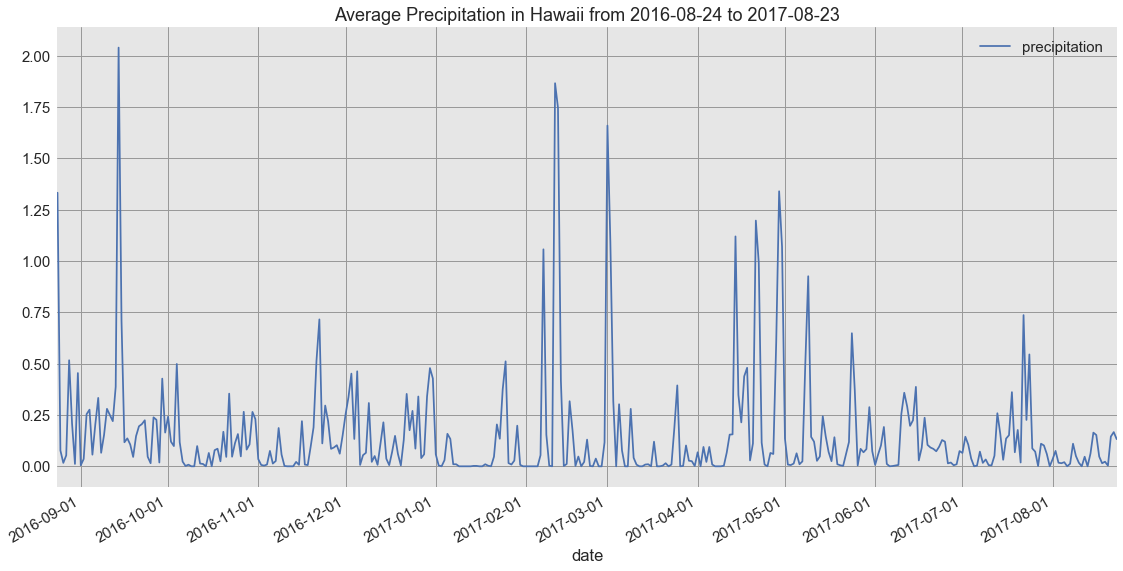

In [5]:
fig, ax = plt.subplots(figsize=(16,8))

df_prcp_summary.plot.line(
    x='date',
    y='precipitation',
    ax=ax
)

plt.minorticks_off()

ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()

plt.tight_layout()
plt.title(f'Average Precipitation in Hawaii from {MAX_DATE_MINUS_12_MONTH} to {MAX_DATE}')
plt.show()

## Step 2 - Station Analysis

* Total Number of Stations

In [6]:
session.query(func.count()).select_from(Station).all()[0][0]

9

* Most Active Stations

In [7]:
cnt = func.count().label('observation')
stn = Measurement.station
df_top_station = pd.read_sql(select([stn, cnt]).group_by(stn).order_by(desc(cnt)), engine)
df_top_station

,station,observation
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


Station USC00519281	 has the highest number of observations.

In [8]:
top_station = df_top_station.at[0, 'station']

* Last 12 month of observation data (tobs)

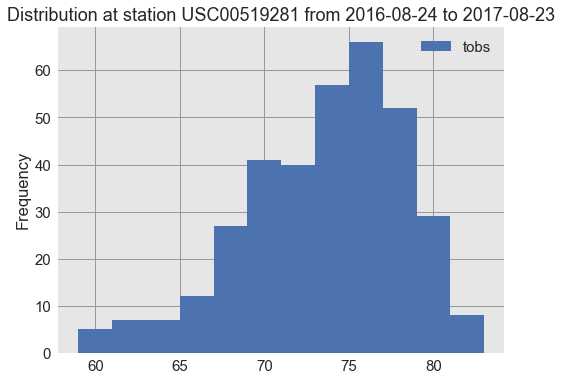

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
pd.read_sql(
    select([Measurement.tobs]).where(
        and_(
            Measurement.station == top_station, 
            Measurement.date.between(MAX_DATE_MINUS_12_MONTH, MAX_DATE)
        )
    ),
    engine
).plot.hist(bins=12, ax=ax)
plt.title(f"Distribution at station {top_station} from {MAX_DATE_MINUS_12_MONTH} to {MAX_DATE}")
plt.show()

## Step3 -Temperature Analysis

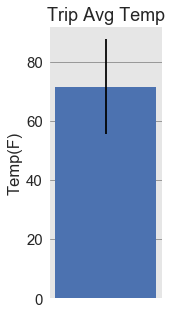

In [10]:
def calc_temps(start_date, end_date):
    temp = Measurement.tobs
    result = session.query(func.min(temp), func.avg(temp), func.max(temp)).filter(
            Measurement.date.between(start_date, end_date)
    )
    return result.all()[0]

(min_temp, avg_temp, max_temp) = calc_temps(VACATION_START_DATE_PREV_YEAR, VACATION_END_DATE_PREV_YEAR)

fig, ax = plt.subplots(figsize=(2,5))
ax.bar([0], [avg_temp], width=1, yerr=max_temp - min_temp)
plt.title('Trip Avg Temp')
plt.ylabel('Temp(F)')
ax.xaxis.set_visible(False)
plt.show()

## Optional Recommended Analysis

### Average Rainfall per station 
Below query use left join the ensure all station are included, reagardless of if measuremednt exists.

In [11]:
session.query(
    Station.station, func.avg(Measurement.prcp)
).outerjoin(
    Measurement, and_(
        Station.station == Measurement.station,
        Measurement.date.between(VACATION_START_DATE_PREV_YEAR, VACATION_END_DATE_PREV_YEAR),
    )
).group_by(
    Station.station
).all()

[('USC00511918', None),
 ('USC00513117', 0.20555555555555557),
 ('USC00514830', 0.17125),
 ('USC00516128', 0.838888888888889),
 ('USC00517948', 0.0),
 ('USC00518838', None),
 ('USC00519281', 0.18555555555555558),
 ('USC00519397', 0.024444444444444446),
 ('USC00519523', 0.0375)]

### Daily Normals

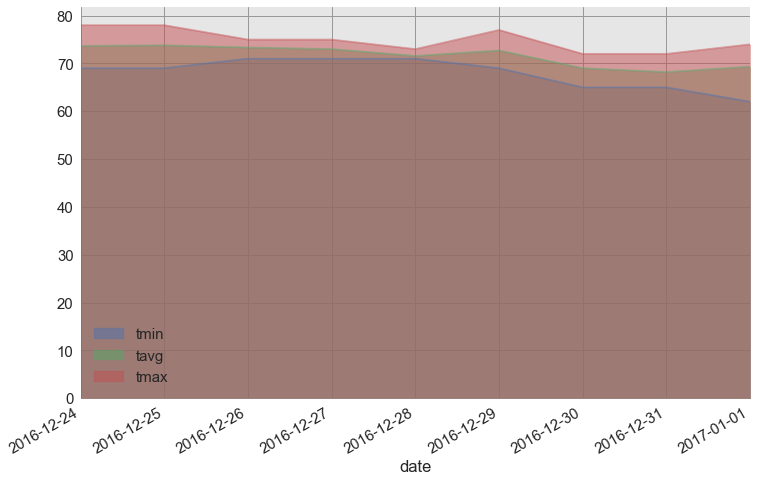

In [12]:
def daily_normals(date):
    tobs = Measurement.tobs
    return session.query(func.min(tobs), func.avg(tobs), func.max(tobs)).filter_by(
        date=date
    ).all()[0]

# Need to pandas.date_range return DateTimeIndex, need to 
# Convert to numpy date for correct plotting label
df_normals = pd.DataFrame(
    [
        [date.date(), *daily_normals(date)] 
        for date in pd.date_range(VACATION_START_DATE_PREV_YEAR, VACATION_END_DATE_PREV_YEAR)
    ],
    columns = ['date', 'tmin', 'tavg', 'tmax']
)

fig, ax = plt.subplots(figsize=(12,8))
df_normals.plot.area(
    x='date',
    stacked=False,
    ax=ax
)
plt.minorticks_off()
ax.xaxis.set_major_locator(dates.DayLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('%Y-%m-%d'))

#ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y-%m-%d'))
#ax.xaxis.set_major_formatter(dates.DateFormatter('%m-%d'))

fig.autofmt_xdate()

# Could use hard coded to 45 degree but I found the default 30 degree is easier to read
#plt.xticks(rotation=45)

plt.show()

In [13]:
session.close()

## Step 4 - Climate App

See [climate_app.py](climate_app.py)